The aim of this is to test working with the NVSS, FIRST and SDSS combined catalogue using their provided testing subsample.

The catalogue sample is provided in fits format, so astropy can be used to read it.

In [1]:
# Importing necessary packages
import math
import os
import glob2 as glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

hdulist = fits.open('small100deg_subset.fits')
hdulist.info()

Filename: small100deg_subset.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    251   16453R x 117C   [J, D, D, J, D, D, A, E, E, E, E, E, E, E, E, E, 12A, J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 8A, J, J, D, D, A, A, E, E, E, E, E, E, 9A, J, D, D, E, E, E, E, E, E, E, E, E, E, E, A, A, A, D, D, I, 19A, E, E, E, E, E, E, E, E, E, E, D, D, I, 19A, E, E, E, E, E, E, E, E, E, E, I, J, I, I, D, D, J, I, I, D, I, I, I, I, I, I, D, I, D, I, D, D, I]   


In [2]:
# hdulist's first HDU is actually empty besides some dummy headers, so the second one is the important one
data = hdulist[1].data

At the moment, this is formatted as 16453 objects, each with 117 columns containing assorted properties. Not all of these will actually be necessary for this, so it'll be useful to isolate the ones which are needed.

If we're interested in seeing how flux density varies with redshift, we'll naturally need these parameters. For flux density, NVSS and FIRST are the surveys of interest, while for redshift we'll want spectroscopic NDSS. The spectroscopic type might also be useful, as it'd let us separate out different types of objects.

Looking up the relevant columns in the catalogue's formatting information:

9: FIRST integrated flux density at 20cm (mJy)
22: NVSS integrated flux at 20cm (mJy)
95: SDSS spectroscopic type (see below)
99: SDSS spectroscopic redshift
100: error in SDSS redshift

Spectroscopic types possible:
-1: unclassifiable
0: no spectroscopic match
1: star
2: galaxy
3: quasar
4: high-redshift quasar
6: late-type star

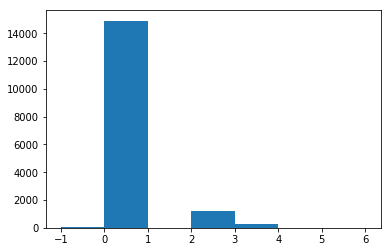

In [3]:
fflux = data['FIRST_FLUX']
nflux = data['NVSS_FLUX']
spectype = data['SPEC_TYPE']
redshift = data['SPEC_REDSHIFT']

plt.hist(spectype, bins=7)
plt.show()

These should now be plottable against each other. What we expect to see is that as redshift increases, the flux of objects detected decreases.

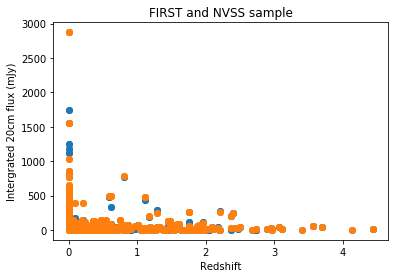

In [4]:
plt.plot(redshift, fflux, 'o', redshift, nflux, 'o')
plt.title('FIRST and NVSS sample')
plt.xlabel('Redshift')
plt.ylabel('Intergrated 20cm flux (mJy)')
plt.show()

Ideally, all the flux values from one survey should perfectly overlap with the other over (assuming sufficiently long observation periods), but as can be seen this isn't always the case.

It might be more useful here to look at luminosity rather than flux; flux is dependent on distance from the source, whereas luminosity is inherent to it. As redshift doesn't have a constant relation to distance, astropy can be used to calculate it (and hence luminosity). Astropy provides distance in Mpc, but as there's a proportional relationship it's not necessary to convert to metres when just looking at behaviour.

In [5]:
mpcdist = cosmo.luminosity_distance(redshift)

flumin = 4*math.pi*mpcdist**2*fflux
nlumin = 4*math.pi*mpcdist**2*nflux

As some redshifts register as zero (and hence distance is set to zero), this will give luminosity values of zero in some cases. These can be removed by setting all zeroes to NaN.

In [6]:
flumin[ flumin == 0 ] = np.nan
nlumin[ nlumin == 0 ] = np.nan
mpcdist[ mpcdist == 0 ] = np.nan

Now these can be plotted again.

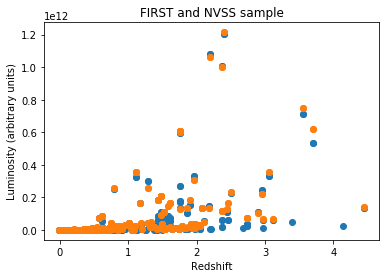

In [7]:
plt.plot(redshift, flumin, 'o', redshift, nlumin, 'o')
plt.title('FIRST and NVSS sample')
plt.xlabel('Redshift')
plt.ylabel('Luminosity (arbitrary units)')
plt.show()

Using this subsample, the behaviour we expect to see - luminosity detected increasing with higher redshift - isn't especially obvious. Now it's necessary to make use of the full catalogue of sources. As only four columns are being used at the moment, it's more helpful to just store those.

In [8]:
fitslist = glob.glob('./Complete_radiocat/Complete*')
    
for i in range(0,len(fitslist)):
    temphdu = fits.open(fitslist[i])
    tempdata = temphdu[1].data
    
    if i == 0:
        
        fullfflux = tempdata['FIRST_FLUX']
        fullnflux = tempdata['NVSS_FLUX']
        fullspectype = tempdata['SPEC_TYPE']
        fullredshift = tempdata['SPEC_REDSHIFT']
    
    else:
    
        tempfflux = tempdata['FIRST_FLUX']
        tempnflux = tempdata['NVSS_FLUX']
        tempspectype = tempdata['SPEC_TYPE']
        tempredshift = tempdata['SPEC_REDSHIFT']
    
        fullfflux = np.append(fullfflux, tempfflux)
        fullnflux = np.append(fullnflux, tempnflux)
        fullspectype = np.append(fullspectype, tempspectype)
        fullredshift = np.append(fullredshift, tempredshift)
        
    temphdu.close()

Now, the same operations performed on the subsample can be used with the full catalogue.

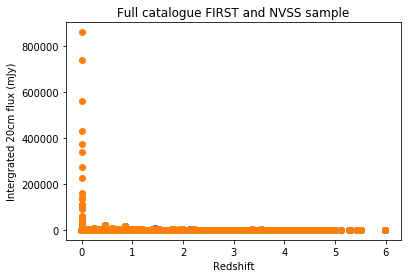

In [9]:
plt.plot(fullredshift, fullfflux, 'o', fullredshift, fullnflux, 'o')
plt.title('Full catalogue FIRST and NVSS sample')
plt.xlabel('Redshift')
plt.ylabel('Intergrated 20cm flux (mJy)')
plt.show()

In [10]:
fullmpcdist = cosmo.luminosity_distance(fullredshift)

fullflumin = 4*math.pi*fullmpcdist**2*fullfflux
fullnlumin = 4*math.pi*fullmpcdist**2*fullnflux

fullflumin[ fullflumin == 0 ] = np.nan
fullnlumin[ fullnlumin == 0 ] = np.nan
fullmpcdist[ fullmpcdist == 0 ] = np.nan

constlumin = np.ones(len(fullredshift))*1e11

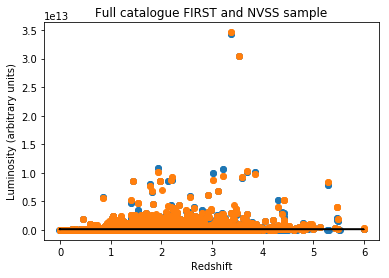

In [11]:
plt.plot(fullredshift, fullflumin, 'o', fullredshift, fullnlumin, 'o', fullredshift, constlumin, 'k')
plt.title('Full catalogue FIRST and NVSS sample')
plt.xlabel('Redshift')
plt.ylabel('Luminosity (arbitrary units)')
plt.show()

To see the behaviour more clearly, it helps to make one or both axes logarithmic.

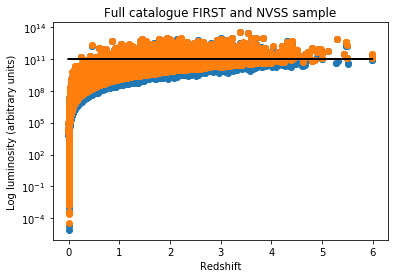

In [12]:
plt.plot(fullredshift, fullflumin, 'o', fullredshift, fullnlumin, 'o', fullredshift, constlumin, 'k')
plt.yscale('log')
plt.title('Full catalogue FIRST and NVSS sample')
plt.xlabel('Redshift')
plt.ylabel('Log luminosity (arbitrary units)')
plt.show()

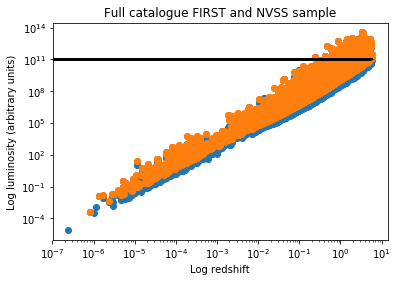

In [13]:
plt.plot(fullredshift, fullflumin, 'o', fullredshift, fullnlumin, 'o', fullredshift, constlumin, 'k')
plt.yscale('log')
plt.xscale('log')
plt.title('Full catalogue FIRST and NVSS sample')
plt.xlabel('Log redshift')
plt.ylabel('Log luminosity (arbitrary units)')
plt.show()